In [ ]:
import jax.numpy as np
from jax import random
from jax.example_libraries import stax
from jax.example_libraries.stax import Dense, Relu

def sample_n01(N, rng):
  D = 2
  return random.normal(rng, (N, D))

def log_prob_n01(x):
  return np.sum(-np.square(x)/2 - np.log(np.sqrt(2*np.pi)),axis=-1)

def nvp_forward(net_params, shift_and_log_scale_fn, x, flip=False):
  d = x.shape[-1]//2
  x1, x2 = x[:, :d], x[:, d:]
  if flip:
    x2, x1 = x1, x2
  shift, log_scale = shift_and_log_scale_fn(net_params, x1)
  y2 = x2*np.exp(log_scale) + shift
  if flip:
    x1, y2 = y2, x1
  y = np.concatenate([x1, y2], axis=-1)
  return y

def nvp_inverse(net_params, shift_and_log_scale_fn, y, flip=False):
  d = y.shape[-1]//2
  y1, y2 = y[:, :d], y[:, d:]
  if flip:
    y1, y2 = y2, y1
  shift, log_scale = shift_and_log_scale_fn(net_params, y1)
  x2 = (y2-shift)*np.exp(-log_scale)
  if flip:
    y1, x2 = x2, y1
  x = np.concatenate([y1, x2], axis=-1)
  return x, log_scale

def init_nvp(rng):
  D = 2
  net_init, net_apply = stax.serial(
    Dense(512), Relu, Dense(512), Relu, Dense(D))
  in_shape = (-1, D//2)
  out_shape, net_params = net_init(rng, in_shape)
  def shift_and_log_scale_fn(net_params, x1):
    s = net_apply(net_params, x1)
    return np.split(s, 2, axis=1)
  return net_params, shift_and_log_scale_fn

def sample_nvp(net_params, shift_log_scale_fn, base_sample_fn, N, flip=False):
  x = base_sample_fn(N)
  return nvp_forward(net_params, shift_log_scale_fn, x, flip=flip)

def log_prob_nvp(net_params, shift_log_scale_fn, base_log_prob_fn, y, flip=False):
  x, log_scale = nvp_inverse(net_params, shift_log_scale_fn, y, flip=flip)
  ildj = -np.sum(log_scale, axis=-1)
  return base_log_prob_fn(x) + ildj

def init_nvp_chain(n, rng):
  flip = False
  ps, configs = [], []
  for i in range(n):
    p, f = init_nvp(rng)
    ps.append(p), configs.append((f, flip))
    flip = not flip
  return ps, configs

def sample_nvp_chain(ps, configs, base_sample_fn, N, rng):
  x = base_sample_fn(N, rng)
  for p, config in zip(ps, configs):
    shift_log_scale_fn, flip = config
    x = nvp_forward(p, shift_log_scale_fn, x, flip=flip)
  return x

def make_log_prob_fn(p, log_prob_fn, config):
  shift_log_scale_fn, flip = config
  return lambda x: log_prob_nvp(p, shift_log_scale_fn, log_prob_fn, x, flip=flip)

def log_prob_nvp_chain(ps, configs, base_log_prob_fn, y):
  log_prob_fn = base_log_prob_fn
  for p, config in zip(ps, configs):
    log_prob_fn = make_log_prob_fn(p, log_prob_fn, config)
  return log_prob_fn(y)

In [ ]:
from typing import Optional

import jax.numpy
import numpy


def gaussian_mixture_energy(coord, means, sigmas, weights):
    """
        Implements an isotropic gaussian mixture energy function.
        This is a good distribution for debugging sampler implementation

        $\sum_{i=O}^{K-1}  w_i  \mathcal N (means_i, sigmas_i)$

        :param coord : [[x,y]] point of shape=(1,2) at which to compute energy.
        :param means : array of 2D means (shape=(K, 2)) for each gaussian dist in mixture
        :param sigmas: array of scalers (shape=(K,)) describing std of each gaussian dist in mixture
        :param weights: array of scalers (shape=(K,)) describing weights of each gaussian dist in mixture
        :return energy value (or -log of unnormalized density)
    """

    diff = coord - means
    numerator = jax.numpy.sum(diff ** 2, axis=1)

    mode_densities = jax.numpy.exp(- numerator / (2 * sigmas ** 2)) / sigmas
    density = jax.numpy.sum(weights * mode_densities)
    return -jax.numpy.log(density)


def gaussian_mixture_sampler(N, means, sigmas, weights, key):
    """
        Implements sampling from an isotropic gaussian mixture energy function.
        This is a good distribution for debugging sampler implementation

        $\sum_{i=O}^{K-1}  w_i  \mathcal N (means_i, sigmas_i)$

        :param N : number of samples to generate
        :param means : array of 2D means (shape=(K, 2)) for each gaussian dist in mixture
        :param sigmas: array of scalers (shape=(K,)) describing std of each gaussian dist in mixture
        :param weights: array of scalers (shape=(K,)) describing weights of each gaussian dist in mixture
        :param key: JAX needs a key for its random number generator, it is just that
        :return samples shape=(N,2)
    """

    # first sample modes
    subkey, key = jax.random.split(key)
    modes = jax.random.choice(subkey, len(weights), shape=(N,), p=weights)

    shape = (N,) + means.shape[1:]
    subkey, key = jax.random.split(key)
    std_normal_samples = jax.random.normal(subkey, shape=shape)
    return std_normal_samples * sigmas[modes].reshape(std_normal_samples.shape[0], 1) + means[modes]


def sample_from_image_density(N, density, key):
    """
        adapted from https://github.com/noegroup/stochastic_normalizing_flows/blob/main/snf_code/snf_code/image.py#L138

        This samples a bin with probability given by density and then perturb the coordinate of bin uniformly

        :param N: number of samples
        :param density: density or value at each pixel
        :param key: JAX needs a key for its random number generator, it is just that
        :return: samples shape=(N,2)
    """
    # normalize
    density = density / density.sum()

    flat_density = density.flatten()
    subkey, key = jax.random.split(key)
    indices = jax.random.choice(subkey, a=len(flat_density), shape=(N,), p=flat_density)

    bins = jax.numpy.stack([indices // (density.shape[0]), indices % (density.shape[0])], axis=1)
    subkey, key = jax.random.split(key)
    samples = bins + jax.random.uniform(subkey, shape=bins.shape) - 0.5
    return samples


def continuous_energy_from_image(coord, xp, yp, zp, fill_value=None):
    """

    :param coord:
    :param xp: see interp2d
    :param yp: see interp2d
    :param zp: see interp2d
    :param fill_value: see interp2d (Note: you can this to enforce some trivial boundary conditions
    :return: energy (based on bilinear interpolation of zp on xp, yp grid. )
    """
    return -jax.numpy.log(interp2d(coord[0], coord[1], xp, yp, zp, fill_value))


def interp2d(
        x: jax.numpy.ndarray,
        y: jax.numpy.ndarray,
        xp: jax.numpy.ndarray,
        yp: jax.numpy.ndarray,
        zp: jax.numpy.ndarray,
        fill_value: Optional[jax.numpy.ndarray] = None,
) -> jax.numpy.ndarray:
    """
    Taken from "https://github.com/adam-coogan/jaxinterp2d/blob/master/src/jaxinterp2d/__init__.py"
    Bilinear interpolation on a grid. ``CartesianGrid`` is much faster if the data
    lies on a regular grid.
    Args:
        x, y: 1D arrays of point at which to interpolate. Any out-of-bounds
            coordinates will be clamped to lie in-bounds.
        xp, yp: 1D arrays of points specifying grid points where function values
            are provided.
        zp: 2D array of function values. For a function `f(x, y)` this must
            satisfy `zp[i, j] = f(xp[i], yp[j])`
    Returns:
        1D array `z` satisfying `z[i] = f(x[i], y[i])`.
    """
    if xp.ndim != 1 or yp.ndim != 1:
        raise ValueError("xp and yp must be 1D arrays")
    if zp.shape != (xp.shape + yp.shape):
        raise ValueError("zp must be a 2D array with shape xp.shape + yp.shape")

    ix = jax.numpy.clip(jax.numpy.searchsorted(xp, x, side="right"), 1, len(xp) - 1)
    iy = jax.numpy.clip(jax.numpy.searchsorted(yp, y, side="right"), 1, len(yp) - 1)

    # Using Wikipedia's notation (https://en.wikipedia.org/wiki/Bilinear_interpolation)
    z_11 = zp[ix - 1, iy - 1]
    z_21 = zp[ix, iy - 1]
    z_12 = zp[ix - 1, iy]
    z_22 = zp[ix, iy]

    z_xy1 = (xp[ix] - x) / (xp[ix] - xp[ix - 1]) * z_11 + (x - xp[ix - 1]) / (
            xp[ix] - xp[ix - 1]
    ) * z_21
    z_xy2 = (xp[ix] - x) / (xp[ix] - xp[ix - 1]) * z_12 + (x - xp[ix - 1]) / (
            xp[ix] - xp[ix - 1]
    ) * z_22

    z = (yp[iy] - y) / (yp[iy] - yp[iy - 1]) * z_xy1 + (y - yp[iy - 1]) / (
            yp[iy] - yp[iy - 1]
    ) * z_xy2

    if fill_value is not None:
        oob = jax.numpy.logical_or(
            x < xp[0], jax.numpy.logical_or(x > xp[-1], jax.numpy.logical_or(y < yp[0], y > yp[-1]))
        )
        z = jax.numpy.where(oob, fill_value, z)

    return z


def prepare_image(rgb, crop=None, embed=None, white_cutoff=225, gauss_sigma=3, background=0.01):
    """
    Taken from https://github.com/noegroup/stochastic_normalizing_flows/blob/main/snf_code/snf_code/image.py
    Transforms rgb image array into 2D-density and energy
    Parameters:
        rgb: RGB image

     ----------
    density : ndarray(width, height)
        Probability density
    energy : ndarray(width, height)
        Energy
    """
    img = rgb

    # make one channel
    img = img.mean(axis=2)

    # make background white
    img = img.astype(numpy.float32)
    img[img > white_cutoff] = 255

    # normalize
    img /= img.max()

    if crop is not None:
        # crop
        img = img[crop[0]:crop[1], crop[2]:crop[3]]

    if embed is not None:
        tmp = numpy.ones((embed[0], embed[1]), dtype=numpy.float32)
        shift_x = (embed[0] - img.shape[0]) // 2
        shift_y = (embed[1] - img.shape[1]) // 2
        tmp[shift_x:img.shape[0] + shift_x, shift_y:img.shape[1] + shift_y] = img
        img = tmp

    # convolve with Gaussian
    from scipy.ndimage import gaussian_filter
    img2 = gaussian_filter(img, sigma=gauss_sigma)

    # add background
    background1 = gaussian_filter(img, sigma=10)
    background2 = gaussian_filter(img, sigma=20)
    background3 = gaussian_filter(img, sigma=50)
    density = (1.0 - img2) + background * (background1 + background2 + background3)

    U = -numpy.log(density)
    U -= U.min()

    return density, U

# see NPEET for different type of information-theoretic metrics
from typing import List, Union

import numpy


def compute_2d_histogram_from_samples(samples, density):
    """
        Compute 2D histogram from samples for samples on a 2D grid.
        This is to be used when sampling from image's density.

    :param samples: 2D samples from image density
    :param density: density derived from the image
    :return: unnormalized density with bin_size 1
    """

    x_dim, y_dim = density.shape

    sample_density, xedges, yedges = numpy.histogram2d(
        samples[:, 0], samples[:, 1], bins=[numpy.arange(0, x_dim + 1), numpy.arange(0, y_dim + 1)],
        density=False
    )

    return sample_density


def compute_coarse_discretization(density, bin_size):
    if isinstance(bin_size, int):
        bin_size = [bin_size, bin_size]

    bin_size_x, bin_size_y = bin_size

    x_dim, y_dim = density.shape

    density_new = numpy.zeros(((x_dim + 1) // bin_size_x, (y_dim + 1) // bin_size_y))
    for i in range(0, density_new.shape[0]):
        for j in range(0, density_new.shape[1]):
            density_new[i, j] = (
                density[i * bin_size_x:(i + 1) * bin_size_x][:,
                j * bin_size_y:(j + 1) * bin_size_y]).sum()

    return density_new


def get_discretized_tv_for_image_density(density, samples, bin_size: Union[int, List[int]] = 1):
    if isinstance(bin_size, int):
        bin_size = [bin_size, bin_size]

    sample_density = compute_2d_histogram_from_samples(samples, density)

    density = compute_coarse_discretization(density, bin_size)
    sample_density = compute_coarse_discretization(sample_density, bin_size)

    sample_density = sample_density / sample_density.sum()
    density = density / density.sum()
    breakpoint()
    return (numpy.abs(density - sample_density)).sum()


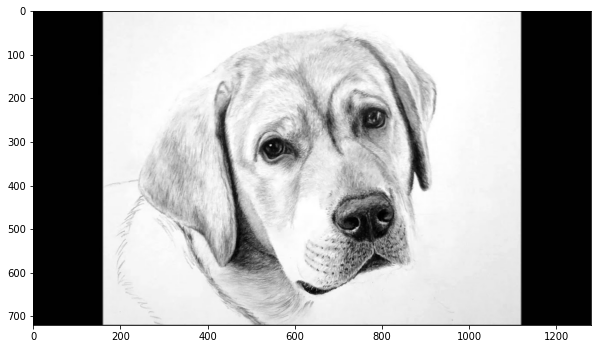

In [ ]:
import matplotlib.image
import matplotlib.pyplot
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import rcParams, ticker, cm
from matplotlib import collections as mc
import numpy as onp 
rcParams['animation.html'] = 'jshtml'  # Makes the default animation an interactive video
rcParams['animation.embed_limit'] = 2**128  # Allow bigger animations

img = matplotlib.image.imread('/content/drive/MyDrive/CS699/homework #2/labrador.jpg')

# plot and visualize
fig = matplotlib.pyplot.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)
ax.imshow(img)
matplotlib.pyplot.show()

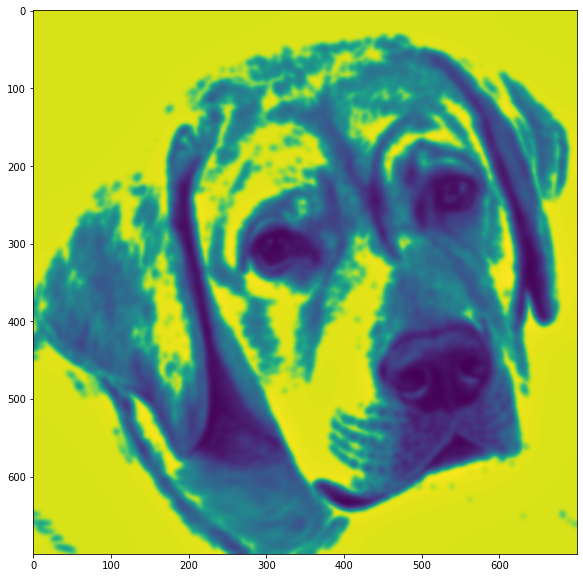

In [ ]:
density, energy = prepare_image(
    img, crop=(10, 710, 240, 940), white_cutoff=225, gauss_sigma=3, background=0.01
)

x_max, y_max = density.shape
xp = jax.numpy.arange(x_max)
yp = jax.numpy.arange(y_max)
zp = jax.numpy.array(density)

# You may use fill value to enforce some boundary conditions or some other way to enforce boundary conditions
energy_fn = lambda coord: continuous_energy_from_image(coord, xp, yp, zp, fill_value=0)
energy_fn_grad = jax.grad(energy_fn)

fig = matplotlib.pyplot.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)
ax.imshow(energy)
matplotlib.pyplot.show()

In [206]:
from jax.example_libraries import optimizers
from jax import jit, grad
import numpy as onp

key = jax.random.PRNGKey(1)
key, subkey = jax.random.split(key)

ps, cs = init_nvp_chain(4, subkey)

def loss(params, batch):
  return -np.mean(log_prob_nvp_chain(params, cs, log_prob_n01, batch))

opt_init, opt_update, get_params = optimizers.adam(step_size=1e-4)

@jit
def step(i, opt_state, batch):
  params = get_params(opt_state)
  g = grad(loss)(params, batch)
  return opt_update(i, g, opt_state)

iters = int(1e4)

data_generator = []
for i in range(iters):
  temp_key = jax.random.PRNGKey(i)
  data_generator.append(np.array(sample_from_image_density(100, density, temp_key)))

opt_state = opt_init(ps)
for i in range(iters):
  opt_state = step(i, opt_state, data_generator[i])

ps = get_params(opt_state)

In [207]:
y = sample_nvp_chain(ps, cs, sample_n01, 30000, subkey)

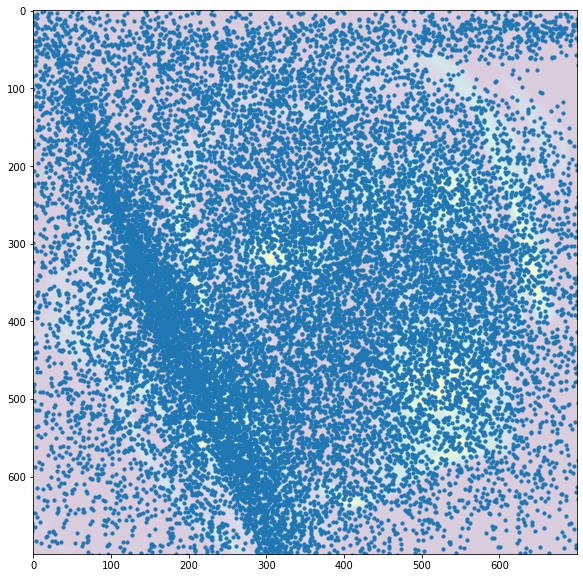

In [209]:
fig = matplotlib.pyplot.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(y[:, 0], y[:, 1], s=10)
ax.imshow(density, alpha=0.2)
matplotlib.pyplot.show()

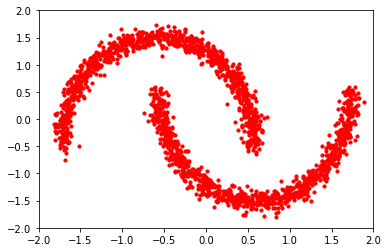

In [ ]:
from sklearn import cluster, datasets, mixture
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
n_samples = 2000
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
X, y = noisy_moons
X = StandardScaler().fit_transform(X)
xlim, ylim = [-2, 2], [-2, 2]
plt.scatter(X[:, 0], X[:, 1], s=10, color='red')
plt.xlim(xlim)
plt.ylim(ylim)

ps, cs = init_nvp_chain(4, key)

def loss(params, batch):
  return -np.mean(log_prob_nvp_chain(params, cs, log_prob_n01, batch))
opt_init, opt_update, get_params = optimizers.adam(step_size=1e-4)

@jit
def step(i, opt_state, batch):
  params = get_params(opt_state)
  g = grad(loss)(params, batch)
  return opt_update(i, g, opt_state)

iters = int(2)
data_generator = (X[onp.random.choice(X.shape[0], 100)] for _ in range(iters))
opt_state = opt_init(ps)
for i in range(iters):
  opt_state = step(i, opt_state, next(data_generator))
ps = get_params(opt_state)

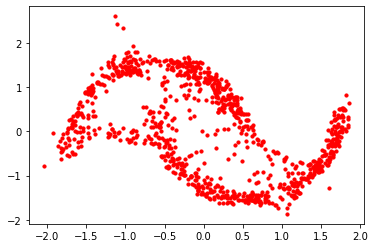

In [ ]:
y = sample_nvp_chain(ps, cs, sample_n01, 1000, subkey)

plt.scatter(y[:, 0], y[:, 1], s=10, color='red')
xlim, ylim = [-3, 3], [-3, 3]

In [ ]:
data_generator = (X[onp.random.choice(X.shape[0], 100)] for _ in range(iters))

In [ ]:
type(next(data_generator))

numpy.ndarray